# A Numba Example

In [8]:
import numpy as np
from numba import vectorize

In [10]:
@vectorize(['float32(float32, float32)'], target='cuda')
def Add(a, b):
    return a + b

# Initialize arrays
N = 100000
A = np.ones(N, dtype=np.float32)
B = np.ones(A.shape, dtype=A.dtype)
C = np.empty_like(A, dtype=A.dtype)

# Add arrays on GPU
C = Add(A, B)
print(C)

[2. 2. 2. ... 2. 2. 2.]


# Massive Parallelism with CUDA Python

Mandelbrot created on GPU in 0.215609 s


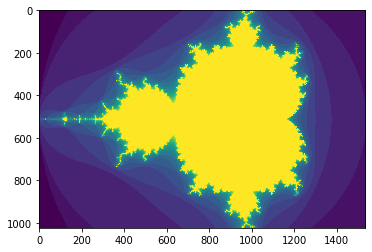

In [23]:
from numba import cuda
import matplotlib.pyplot as plt

@cuda.jit(device=True)
def mandel(x, y, max_iters):
  """
  Given the real and imaginary parts of a complex number,
  determine if it is a candidate for membership in the Mandelbrot
  set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
        return i

  return max_iters

@cuda.jit
def mandel_kernel(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height

  startX = cuda.blockDim.x * cuda.blockIdx.x + cuda.threadIdx.x
  startY = cuda.blockDim.y * cuda.blockIdx.y + cuda.threadIdx.y
  gridX = cuda.gridDim.x * cuda.blockDim.x;
  gridY = cuda.gridDim.y * cuda.blockDim.y;

  for x in range(startX, width, gridX):
    real = min_x + x * pixel_size_x
    for y in range(startY, height, gridY):
      imag = min_y + y * pixel_size_y 
      image[y, x] = mandel(real, imag, iters)

gimage = np.zeros((1024, 1536), dtype = np.uint8)
blockdim = (32, 8)
griddim = (32,16)

start = timer()
d_image = cuda.to_device(gimage)
mandel_kernel[griddim, blockdim](-2.0, 1.0, -1.0, 1.0, d_image, 20) 
d_image.to_host()
dt = timer() - start

print ("Mandelbrot created on GPU in %f s" % dt)

plt.imshow(gimage)

# Using basic numba functionalities (Just @jit it!)

In [31]:
import os
import numpy as np # Numba supports many functions from numpy (https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html)
from numba import jit, njit, vectorize, cuda
import math # Numba supports many functions from math (http://numba.pydata.org/numba-doc/0.17.0/reference/pysupported.html)

import matplotlib.pyplot as plt
import cProfile

In [34]:
a = np.ones((1, 100), dtype=np.float64)
b = np.ones((100, 1), dtype=np.float64)


In [35]:
# simple python function 

def func(a, b):
  for i in range(100000):
    constant = math.pow((a@b)[0][0], 1./2)/math.exp((a@b)[0][0]/1000)
    a = np.array([[constant]*100], dtype=np.float64)
  return a

In [36]:
%timeit res = func(a, b)

813 ms ± 2.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
cProfile.run('func(a, b)')

         300004 function calls in 0.885 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.442    0.442    0.885    0.885 <ipython-input-35-ddff08827d39>:3(func)
        1    0.000    0.000    0.885    0.885 <string>:1(<module>)
        1    0.000    0.000    0.885    0.885 {built-in method builtins.exec}
   100000    0.011    0.000    0.011    0.000 {built-in method math.exp}
   100000    0.019    0.000    0.019    0.000 {built-in method math.pow}
   100000    0.414    0.000    0.414    0.000 {built-in method numpy.array}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [38]:
#
# Numba with nopython = True
#

@njit      # or @jit(nopython=True)
def njit_func(a, b):
  for i in range(100000):
    constant = math.pow((a@b)[0][0], 1./2)/math.exp((a@b)[0][0]/1000)
    a = np.array([[constant]*100], dtype=np.float64)
  return a

In [55]:
%timeit res = njit_func(a, b)
print("----------------------------")
cProfile.run('njit_func(a, b)')

72.3 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
----------------------------
         4 function calls in 0.073 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.073    0.073    0.073    0.073 <ipython-input-38-e96d535033a8>:5(njit_func)
        1    0.000    0.000    0.073    0.073 <string>:1(<module>)
        1    0.000    0.000    0.073    0.073 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [43]:
#
# Basic Numba compiler with type information provided
#

@jit('float64(float64, float64)')
def jit_func(a, b):
    for i in range(100000):
        constant = math.pow((a@b)[0][0], 1./2)/math.exp((a@b)[0][0]/1000)
        a = np.array([[constant]*100], dtype=np.float64)
    return a

<ipython-input-43-5639fda0e558>:5: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "jit_func" failed type inference due to: Invalid use of Function(<built-in function matmul>) with argument(s) of type(s): (float64, float64)
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: typing of intrinsic-call at <ipython-input-43-5639fda0e558> (8)

File "<ipython-input-43-5639fda0e558>", line 8:
def jit_func(a, b):
    <source elided>
    for i in range(100000):
        constant = math.pow((a@b)[0][0], 1./2)/math.exp((a@b)[0][0]/1000)
        ^

  @jit('float64(float64, float64)')
<ipython-input-43-5639fda0e558>:5: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "jit_func" failed type infere

In [56]:
%timeit res = jit_func(a, b)
print("----------------------------")
cProfile.run('jit_func(a, b)')

72 ms ± 249 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
----------------------------
         104 function calls (99 primitive calls) in 0.073 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1009(_handle_fromlist)
        2    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:416(parent)
      2/1    0.072    0.036    0.072    0.072 <ipython-input-43-5639fda0e558>:5(jit_func)
        1    0.000    0.000    0.073    0.073 <string>:1(<module>)
        2    0.000    0.000    0.000    0.000 <string>:1(__new__)
        4    0.000    0.000    0.000    0.000 abc.py:137(__instancecheck__)
        2    0.000    0.000    0.000    0.000 abstract.py:109(__repr__)
      8/6    0.000    0.000    0.000    0.000 abstract.py:112(__hash__)
        2    0.000    0.000    0.000    0.000 abstract.py:115(__eq__)
        2    0.000    0.000    0.0

Text(0.5, 0, 'Method')

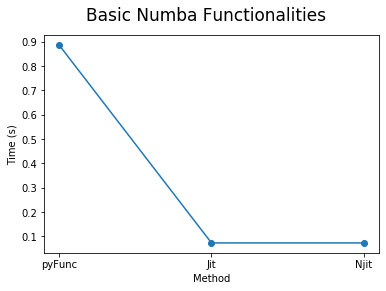

In [57]:
fig, ax = plt.subplots(1, 1)
ax.plot(["a", "b", "c"], [0.885, 0.073, 0.073], "-o") # Results without caching
ax.set_xticklabels(["pyFunc", "Jit", "Njit"])
fig.suptitle("Basic Numba Functionalities", fontsize=17)
ax.set_ylabel("Time (s)")
ax.set_xlabel("Method")

# The @vectorize wrapper

### Simple Vectorize 

In [58]:
#
# Making Ufuncs with Numba.
#

@vectorize
def vec_func(a, b):
  # Now we can pass arrays too, and operate
  # inside like they are scalars:
  for i in range(100000):
    a = math.pow(a*b, 1./2)/math.exp(a*b/1000)
  return a
# This is similar to functions before, for comparison. But...



In [59]:
%timeit res = vec_func(a, b)


26.5 s ± 64.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
#
# This is slow because previously we were doing some
# operations on 1,00,000 scalars obtained by multiplying
# (a@b), but now we are multiplying individual elements 
# of a and b for 1,00,000 times. Also numba is taking care
# of broadcasting too. So, in this case we are applying this
# loop for 100 times.
#
#res.shape # Previously it was (1, 100)



### Vectorize Parallel

In [63]:
@vectorize(['float64(float64, float64)'], target='parallel')
def vecParallel_func(a, b):
  for i in range(100000):
    a = math.pow(a*b, 1./2)/math.exp(a*b/1000)
  return a

In [64]:
%timeit res = vecParallel_func(a, b)

3.46 s ± 18.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [65]:
res = vecParallel_func(a, b)
print(res.shape)

(100, 100)


### Vectorize Cuda 

In [66]:
@vectorize(['float64(float64, float64)'], target='cuda')
def vecCuda_func(a, b):
  for i in range(100000):
    a = math.pow(a*b, 1./2)/math.exp(a*b/1000)
  return a

In [67]:
%timeit res = vecCuda_func(a, b)

2.53 s ± 857 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0.5, 0, 'Method')

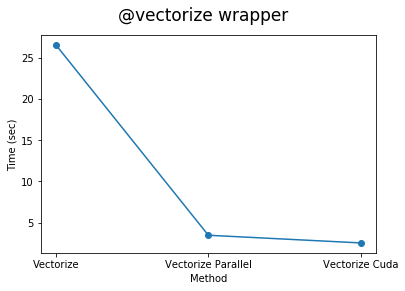

In [71]:
fig, ax = plt.subplots(1, 1)
ax.plot(["a", "b", "c"], [26.5, 3.46, 2.53], "-o")
ax.set_xticklabels(["Vectorize", "Vectorize Parallel", "Vectorize Cuda"])
fig.suptitle("@vectorize wrapper", fontsize=17)
ax.set_ylabel("Time (sec)")
ax.set_xlabel("Method")

### Running your functions on GPU 

In [88]:
@cuda.jit
def cudaKernal_func(a, b, result): # cuda.jit does not return result yet
  pos = cuda.grid(1)
  if (pos < a.shape[1]) and (pos < b.shape[0]):
    for i in range(100000):
      result[pos] = math.exp(a[0][pos]*b[pos][0])

In [89]:
result = np.zeros((100,), dtype=np.float64)

In [90]:
threadsperblock = 32
blockspergrid = (100 + 31) // 32 # blockspergrid = (array.size + (threadsperblock - 1)) // threadsperblock

%timeit cudaKernal_func[threadsperblock, blockspergrid](a, b, result)

85.1 ms ± 9.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [92]:
#
# Here, we have only used it for 1D arrays. You can use it for any Tensor. For eg:
# For 2D array operations you would have used: x, y = cuda.grid(2)
#

In [152]:
@cuda.jit(device=True)
def cudaDevice_func(a, b):
    for i in range(100000):
        a = math.exp(a*b)
    return a

In [153]:
@cuda.jit
def cudaKernal_func2(a, b, result): # cuda.jit does not return result yet
    pos = cuda.grid(1)
    if (pos < a.shape[1]) and (pos < b.shape[0]):
        result[pos] = cudaDevice_func(a[0][pos], b[pos][0])


In [154]:
%timeit cudaKernal_func2[threadsperblock, blockspergrid](a, b, result)

53.1 ms ± 38.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Reference

Link - https://towardsdatascience.com/speed-up-your-algorithms-part-2-numba-293e554c5cc1